In [1]:
import pandas as pd
import matplotlib.pylab as plt

In [2]:
price_df = pd.read_csv('./data/twlo_prices.csv')
price_df.head()

,close,volume,date
0,99.98,93417.0,2020-01-02 14:30:00+00:00
1,99.78,16685.0,2020-01-02 14:31:00+00:00
2,100.14,21998.0,2020-01-02 14:32:00+00:00
3,100.35,18348.0,2020-01-02 14:33:00+00:00
4,100.55,22181.0,2020-01-02 14:34:00+00:00


In [3]:
price_df.index = pd.to_datetime(price_df['date'])
price_df.index = price_df.index.tz_convert('US/Pacific')

price_df.head()

,close,volume,date
date,,,
2020-01-02 06:30:00-08:00,99.98,93417.0,2020-01-02 14:30:00+00:00
2020-01-02 06:31:00-08:00,99.78,16685.0,2020-01-02 14:31:00+00:00
2020-01-02 06:32:00-08:00,100.14,21998.0,2020-01-02 14:32:00+00:00
2020-01-02 06:33:00-08:00,100.35,18348.0,2020-01-02 14:33:00+00:00
2020-01-02 06:34:00-08:00,100.55,22181.0,2020-01-02 14:34:00+00:00


In [4]:
del price_df['date']

<AxesSubplot: xlabel='date'>

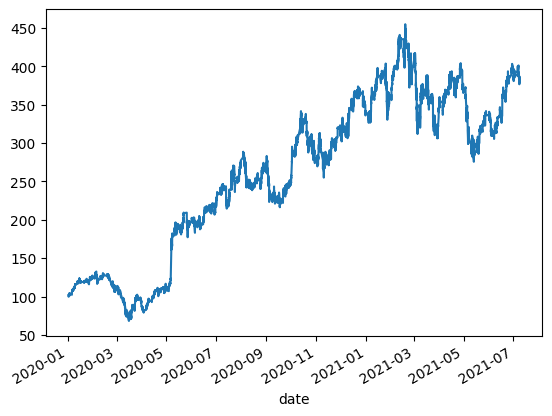

In [5]:
price_df['close'].plot()

In [6]:
last_price_of_the_day = price_df.groupby(price_df.index.date).tail(1)['close'].rename('day_close_price')
last_price_of_the_day.index = last_price_of_the_day.index.date
price_df['day'] = price_df.index.date
price_df = price_df.merge(last_price_of_the_day,left_on='day',right_index=True)
price_df['pct_change_eod'] = (price_df['day_close_price'] - price_df['close'])/price_df['close']
price_df['stock_price_rose'] = price_df['pct_change_eod'] > 0
price_df.head()

,close,volume,day,day_close_price,pct_change_eod,stock_price_rose
date,,,,,,
2020-01-02 06:30:00-08:00,99.98,93417.0,2020-01-02,103.15,0.031706,True
2020-01-02 06:31:00-08:00,99.78,16685.0,2020-01-02,103.15,0.033774,True
2020-01-02 06:32:00-08:00,100.14,21998.0,2020-01-02,103.15,0.030058,True
2020-01-02 06:33:00-08:00,100.35,18348.0,2020-01-02,103.15,0.027902,True
2020-01-02 06:34:00-08:00,100.55,22181.0,2020-01-02,103.15,0.025858,True


In [7]:
# 日付・時刻特徴量
price_df['feature__dayofweek'] = price_df.index.day_of_week
price_df['feature__morning'] = price_df.index.hour < 12

In [8]:
# ラグ特徴量
price_df['feature__lag_30_min_ago_price'] = price_df['close'].shift(30,freq='T')
price_df['feature__lag_7_day_ago_price'] = price_df['close'].shift(7,freq='D')

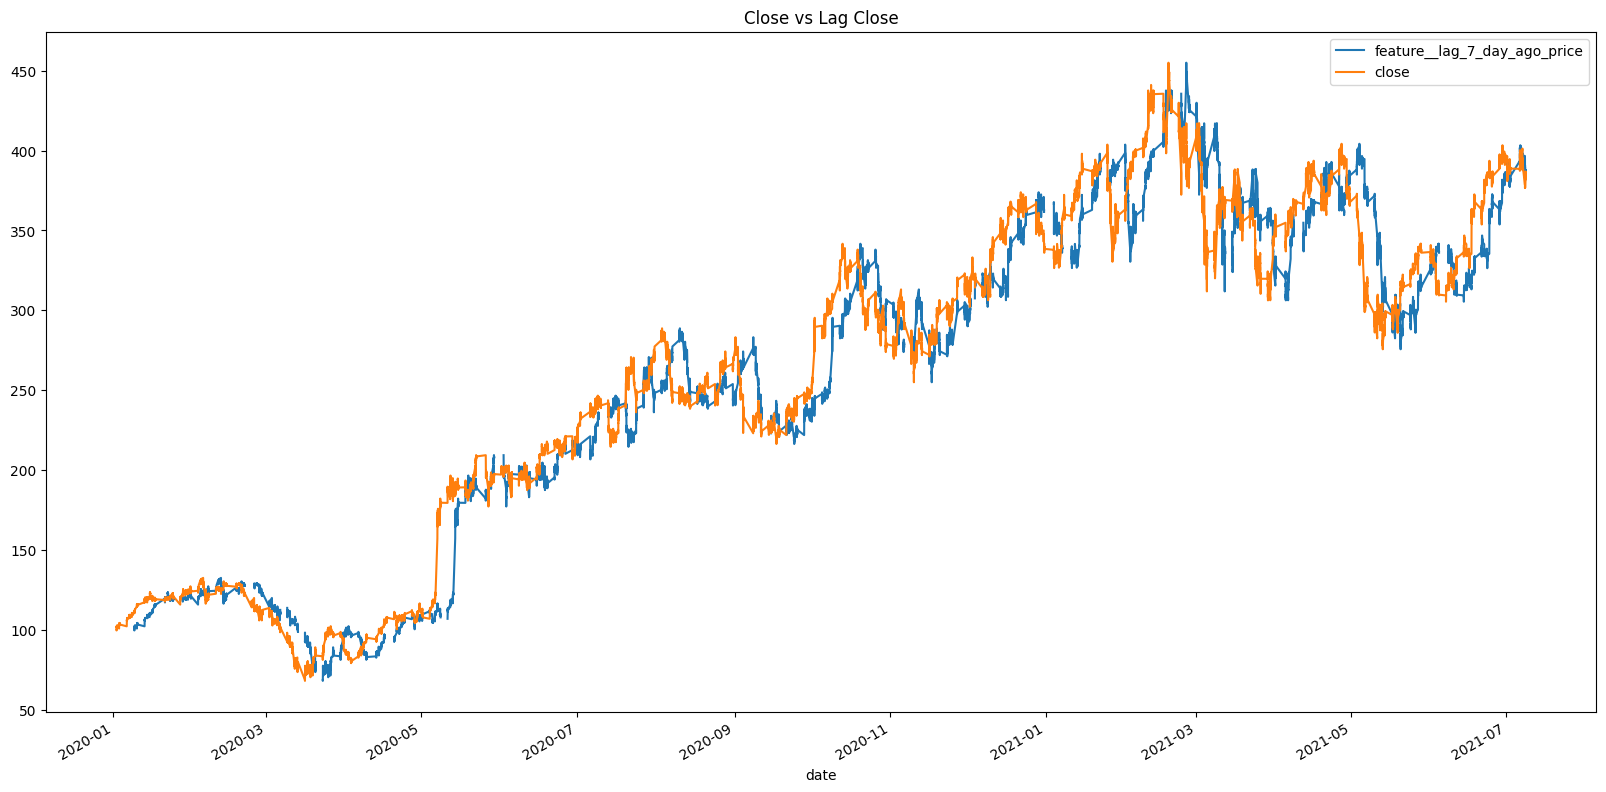

In [9]:
price_df['feature__lag_7_day_ago_price'].plot(figsize=(20,10),title='Close vs Lag Close')
price_df['close'].plot()
plt.legend()

In [10]:
# ローリング特徴量
price_df['feature__rolling_close_mean_60'] = price_df['close'].rolling('60min').mean()
price_df['feature__rolling_close_std_60'] = price_df['close'].rolling('60min').std()
price_df['feature__rolling_volume_mean_60'] = price_df['volume'].rolling('60min').mean()
price_df['feature__rolling_volume_std_60'] = price_df['volume'].rolling('60min').std()

In [11]:
price_df.dropna(inplace=True)

In [12]:
# エクスパンディング特徴量
price_df['feature__expanding_close_mean'] = price_df['close'].expanding(200).mean()
price_df['feature__expanding_volume_mean'] = price_df['volume'].expanding(200).mean()

price_df.dropna(inplace=True)

Text(0, 0.5, 'Volume')

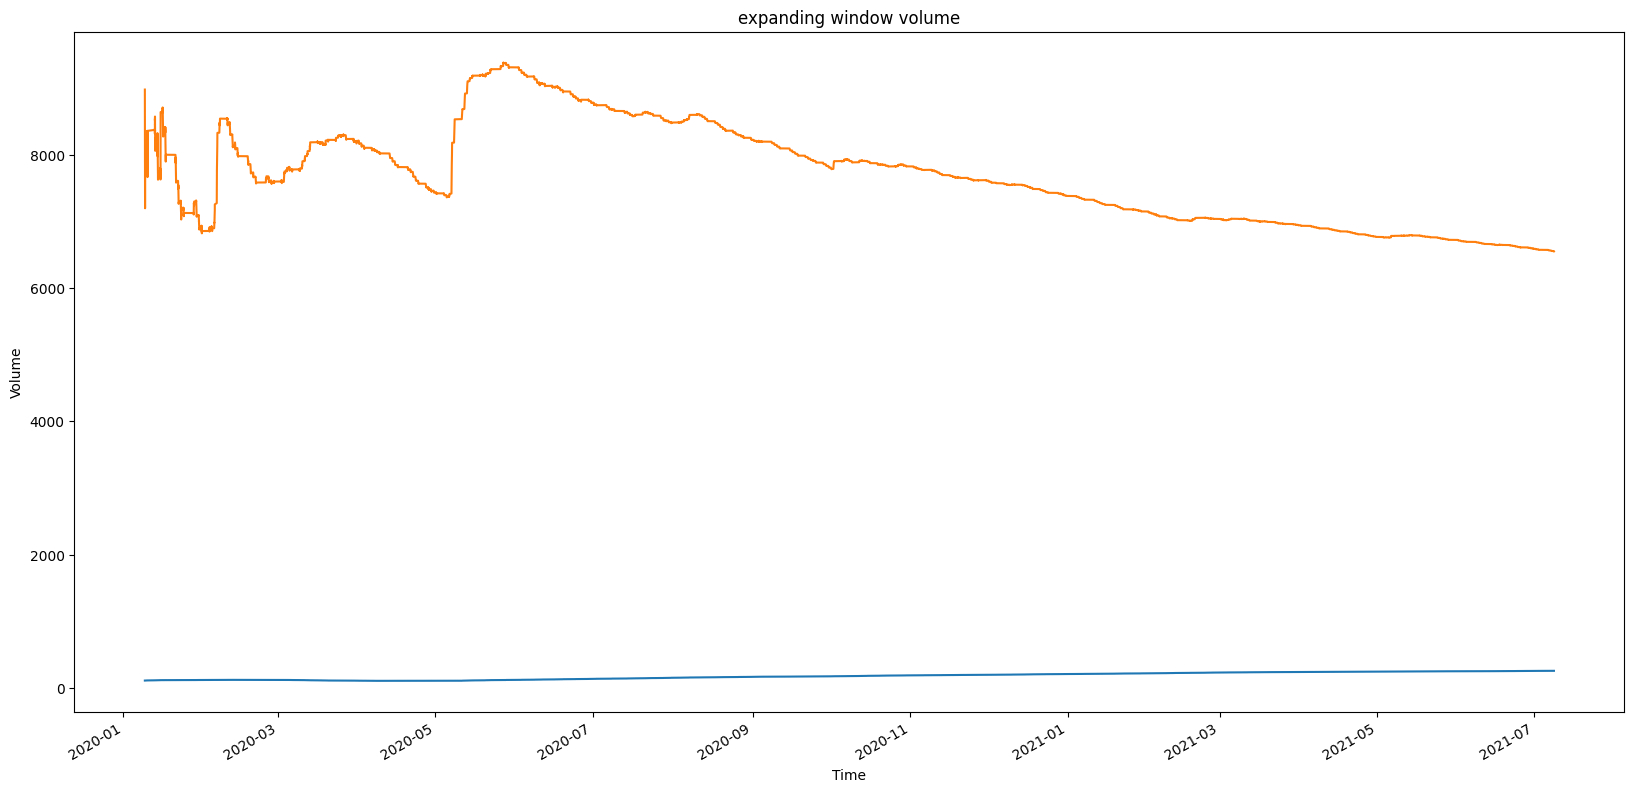

In [15]:
price_df['feature__expanding_close_mean'].plot(figsize=(20,10),title='expanding window close')
plt.xlabel('Time')
plt.ylabel('Price')

price_df['feature__expanding_volume_mean'].plot(figsize=(20,10),title='expanding window volume')
plt.xlabel('Time')
plt.ylabel('Volume')

In [16]:
# ベースラインモデルの作成
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [17]:
clf = RandomForestClassifier(random_state=28)

ml_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', clf)
])

params = {
    'classifier__criterion': ['gini','entropy'],
    'classifier__min_samples_split': [2,3,5],
    'classifier__max_depth': [10,None],
    'classifier__max_features': [None,'auto']
}

In [18]:
# 時系列交差検証
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [20]:
for i, (train_index, test_index) in enumerate(tscv.split(price_df)):
    train_times, test_times = price_df.iloc[train_index].index,price_df.iloc[test_index].index
    
    print(f'Iterarion {i}\n------------')
    print('Training between ' + str(train_times.min().date())
            + ' and ' + str(train_times.max().date()) + '.\n'
            + 'Testing between ' + str(test_times.min().date())
            + ' and ' + str(test_times.max().date()) + '\n')

Iterarion 0
------------
Training between 2020-01-09 and 2020-04-06.
Testing between 2020-04-06 and 2020-07-01

Iterarion 1
------------
Training between 2020-01-09 and 2020-07-01.
Testing between 2020-07-01 and 2020-09-25

Iterarion 2
------------
Training between 2020-01-09 and 2020-09-25.
Testing between 2020-09-25 and 2020-12-22

Iterarion 3
------------
Training between 2020-01-09 and 2020-12-22.
Testing between 2020-12-22 and 2021-03-30

Iterarion 4
------------
Training between 2020-01-09 and 2021-03-30.
Testing between 2021-03-30 and 2021-07-08



In [28]:
# データのフィルタリングと分割
def split_data(price_df):
    downsized_price_df = price_df[(price_df.index.minute == 0)]
    train_df, test_df = downsized_price_df[:'2021-05-31'],downsized_price_df['2021-06-01':]
    train_X, test_X = train_df.filter(regex='feature'),test_df.filter(regex='feature')
    train_y, test_y = train_df['stock_price_rose'], test_df['stock_price_rose']
    return train_df,test_df,train_X,train_y,test_X,test_y

In [32]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
import time

In [24]:
def advanced_grid_search(x_train, y_train, x_test, y_test, ml_pipeline, params, cv=3, include_probas=False, is_regression=False):
    ''' 
    This helper function will grid search a machine learning pipeline with feature engineering included
    and print out a classification report for the best param set. 
    Best here is defined as having the best cross-validated accuracy on the training set
    '''
    
    model_grid_search = GridSearchCV(ml_pipeline, param_grid=params, cv=cv, error_score=-1)
    start_time = time.time()  # capture the start time

    model_grid_search.fit(x_train, y_train)

    best_model = model_grid_search.best_estimator_
    
    y_preds = best_model.predict(x_test)
    
    if is_regression:
        rmse = np.sqrt(mean_squared_error(y_pred=y_preds, y_true=test_set['pct_change_eod']))
        print(f'RMSE: {rmse:.5f}')
    else:
        print(classification_report(y_true=y_test, y_pred=y_preds))
    print(f'Best params: {model_grid_search.best_params_}')
    end_time = time.time()
    print(f"Overall took {(end_time - start_time):.2f} seconds")
    
    if include_probas:
        y_probas = best_model.predict_proba(x_test).max(axis=1)
        return best_model, y_preds, y_probas
    
    return best_model, y_preds

In [33]:
# ベースラインモデルの実行
train_df,test_df,train_X,train_y,test_X,test_y = split_data(price_df)

print("Date-time/Lag/Window features + Random Forest\n================")
best_model,test_preds,test_probas = advanced_grid_search(
    train_X,train_y,
    test_X,test_y,
    ml_pipeline,params,
    cv=tscv,include_probas=True
)

Date-time/Lag/Window features + Random Forest


/home/koumon/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/koumon/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/koumon/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

              precision    recall  f1-score   support

       False       0.52      0.86      0.65        72
        True       0.52      0.16      0.24        69

    accuracy                           0.52       141
   macro avg       0.52      0.51      0.45       141
weighted avg       0.52      0.52      0.45       141

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_split': 5}
Overall took 40.10 seconds
